In [ ]:
%pip install matplotlib
%pip install numpy
%pip install keras
%pip install tensorflow-cpu
%matplotlib inline

# Introduction to Deep Learning with Keras/TensorFlow

**Con Vu** (Adapted From **Daniel Moser** with resources from **Xavier Snelgrove** and **Yash Katariya**)

## Content


**I. Introduction**

1. Task description
2. Dataset

**II. Basic DL Workflow**

1. Preparing input data
2. Building a neural network
3. Training
4. Evaluating

**III. Basic DL Performance Improvement**

1. More data!
2. Regularization
4. Deeper network
5. A new network architecture




##I. Introduction: Classification of handwritten digits

**Goal**:

> The artificial neural network should identify the digit (0-9) from its handwritten image.



**Method**:


> Supervised learning is used. The network is presented with thousands of images and tries to produce predictions of digits. Based on the discrepancy between the predictions and the true values (or labels), the weights of the network are adjusted.



**Dataset**:


> The MNIST database is used, which contains 70,000 images and corresponding labels.



<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

##II. Basic DL Workflow

First, some software needs to be loaded into the Python environment.

In [ ]:
import numpy as np                        # Library for matrix/vector calculation
import matplotlib.pyplot as plt           # Library for plotting
import random                             # Generating randomness
from keras.datasets import mnist          # Load MNIST dataset from keras library
from keras.models import Sequential       # Load sequential model architecture
from keras.layers import Dense, Dropout, Activation   # Load building blocks for the model
import tensorflow as tf                   # Load tensorflow as DL backend
from tensorflow.keras import utils        # Utilities

###1. Preparing input data

The MNIST dataset could be load directly.

The data preprocessing and labelling steps have already be done for us:

*   Handwritten images were isolated from each other (1 image = 1 digit)
*   All images are uniformly formatted to 28 x 28 pixels
*   Images were already labelled (humans have assigned digit to each image)
*   Images and Labels were already segmented into train data, train labels, test data and test labels







In [ ]:
# Load dataset into python environment
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# For demonstrative purpose, we first used a subset of the train data
X_train = X_train[:10000]
y_train = y_train[:10000]

print("Train data (X_train) shape", X_train.shape)
print("Train label (y_train) shape", y_train.shape)
print("Test data (X_test) shape", X_test.shape)
print("Test label (y_test) shape", y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
Train data (X_train) shape (10000, 28, 28)
Train label (y_train) shape (10000,)
Test data (X_test) shape (10000, 28, 28)
Test label (y_test) shape (10000,)


Using matplotlib, we can visualize some of the data and labels from the training set

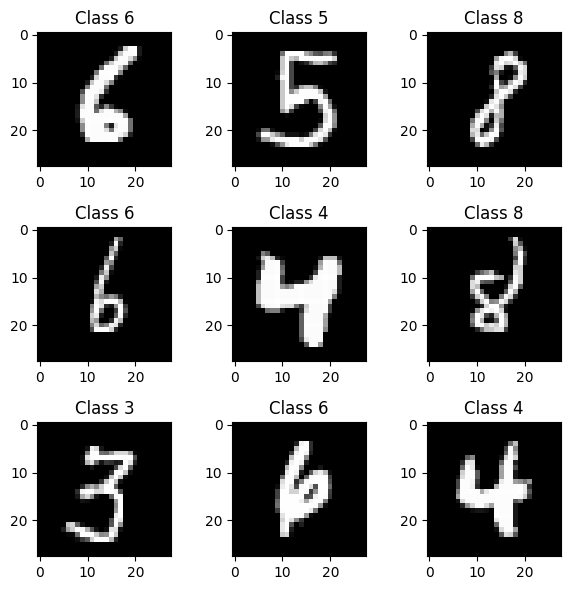

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [ ]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!
print(f'True label: {y_train[num]}')
print('Input: ')
matprint(X_train[num])

True label: 4
Input: 
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    7  108  190    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0   70  252  137    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0  101  252  168    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0   95  136    0    0    0    0    0   17  209  252  210    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0    0   43  230  230    0 

For convenience purpose, instead of a `28 x 28` matrix, the network input will accept a `784 x 1` vector. Each image needs to be then reshaped (or flattened).

We'll also normalize the input values to be in the range `[0-1]` rather than `[0-255]`. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' >

In [ ]:
X_train = X_train.reshape(-1, 784) # reshape 28 x 28 matrices into 784 x 1 vectors.
X_test = X_test.reshape(-1, 784) # -1 means we keep the other dimension of the dataset (i.e. number of images)

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (10000, 784)
Testing matrix shape (10000, 784)


We then encode the labels (digits) into "one-hot format", i.e.

`0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]`

`1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]`

`2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]`

With this one-hot encoding, we can intepret the labels as the probabilities of each digits (0-9)

For example, if the output of the DL model is:

`[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]`

then it is most probable that the image is that of the digit `1`.

In [ ]:
nb_classes = 10 # number of unique digits

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

###2. Building a Neural network: 3-layer fully connected (FC) network

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

First, we define the overall architecture type.

Here, a "Sequential" architecture is used. It is a linear stack of layers, with no loop or short-cut connections

In [ ]:
model = Sequential()

The first layer (input layer) is a set of 512 nodes (artificial neurons).

Each node will receive elements from each input vector and apply some weight and bias to it.

Mathematically, this is equivalent to a matrix multiplication:
`y = Ax + B`, where `x` is the `1 x 784` input vector, `y` is the `1 x 512` output vector, `A` is a `784 x 512` matrix, `B` is a `1 x 512` bias vector

In [ ]:
model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!

An "activation" is a non-linear function applied to the output of the layer above.

It checks the new value of the node, and decides whether that artifical neuron has fired.

The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.

Those inputs are then not considered to be fired.

Positive values of a node are unchanged.

$$f(x) = max (0,x)$$
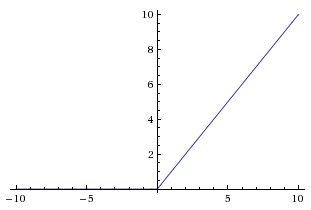

In [ ]:
model.add(Activation('relu'))

Now we add the second (hidden) layer, also with 512 nodes (and thus `1 x 512` output)

In [ ]:
model.add(Dense(512))
model.add(Activation('relu'))

Finally is the output layer with 10 nodes (as we would like to obtain `1 x 10` output vector in "one-hot" format).

This time, we use "softmax" as the activation. "Softmax" scale the output vector, so that all values are ***non-negative***, and **sum up to 1**.

In this way, the output vector represents the probability of being each of the 0-9 digits.

In [ ]:
model.add(Dense(10))
model.add(Activation('softmax'))

We print the summary of the model:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trai

## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

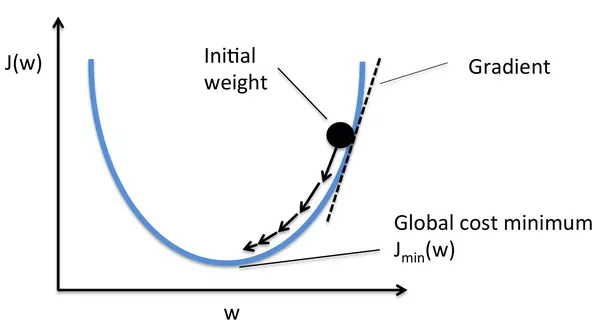

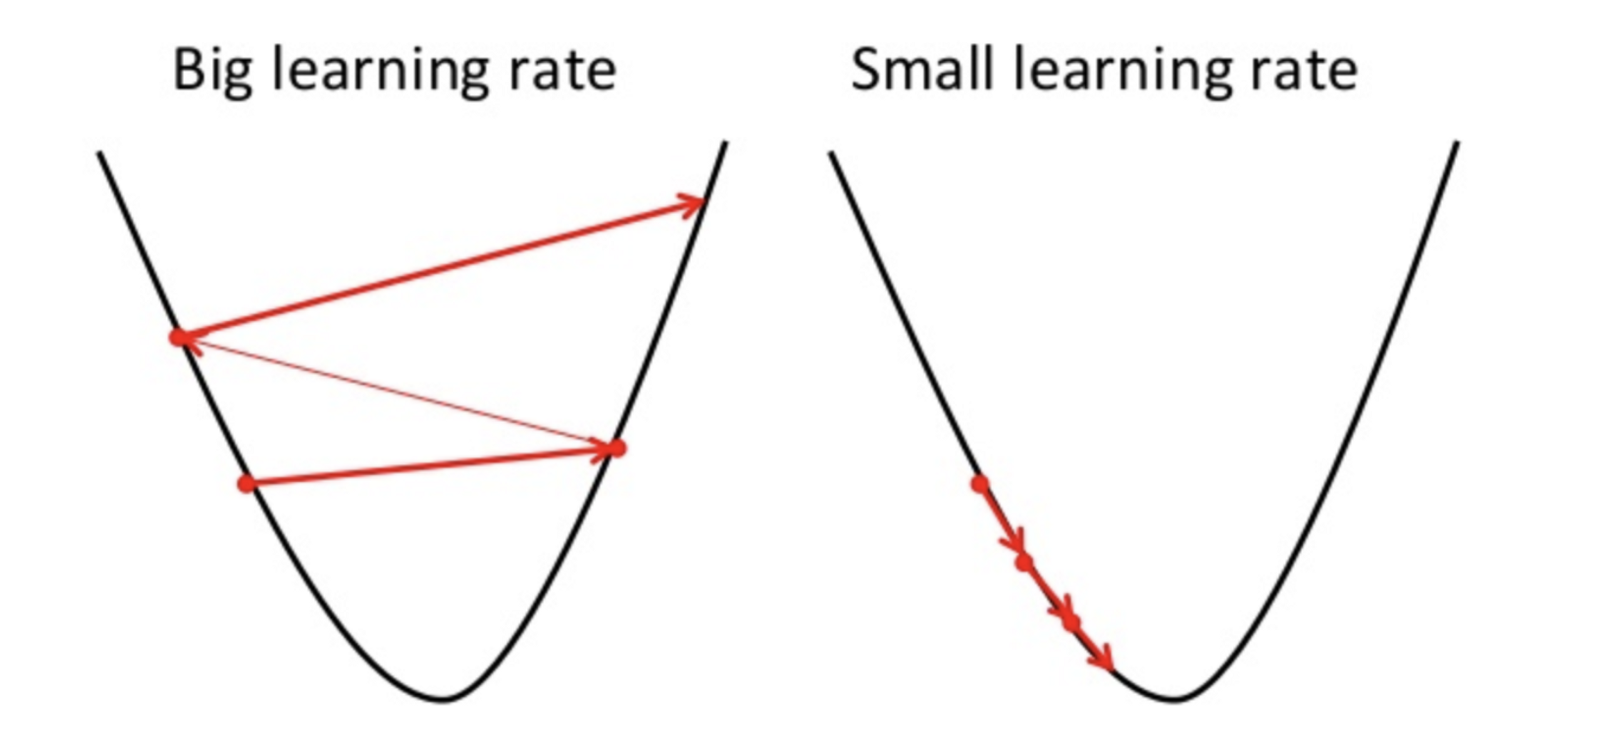

So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.

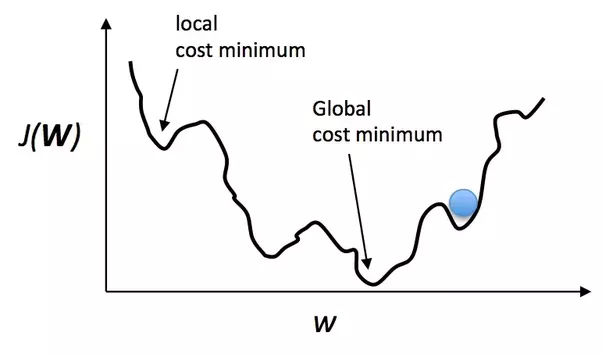

In [ ]:
# Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model!
This is the fun part!

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

In [ ]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=8,
          verbose=1)

Epoch 1/8
79/79 [==============================] - 3s 21ms/step - loss: 0.5039 - accuracy: 0.8568
Epoch 2/8
79/79 [==============================] - 1s 18ms/step - loss: 0.1840 - accuracy: 0.9457
Epoch 3/8
79/79 [==============================] - 2s 20ms/step - loss: 0.1063 - accuracy: 0.9682
Epoch 4/8
79/79 [==============================] - 2s 24ms/step - loss: 0.0732 - accuracy: 0.9781
Epoch 5/8
79/79 [==============================] - 2s 26ms/step - loss: 0.0472 - accuracy: 0.9868
Epoch 6/8
79/79 [==============================] - 2s 30ms/step - loss: 0.0250 - accuracy: 0.9941
Epoch 7/8
79/79 [==============================] - 3s 39ms/step - loss: 0.0191 - accuracy: 0.9954
Epoch 8/8
79/79 [==============================] - 2s 29ms/step - loss: 0.0091 - accuracy: 0.9985


The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.1407 - accuracy: 0.9608
Test score: 0.14073395729064941
Test accuracy: 0.9607999920845032


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [ ]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

print(predictions[0])
print(predicted_classes[0])

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

313/313 [==============================] - 1s 3ms/step
[7.3275790e-09 2.2447435e-09 2.9540035e-06 5.5493343e-05 2.2655596e-11
 1.8952429e-08 1.9467026e-13 9.9994105e-01 4.2861746e-08 3.3898078e-07]
7


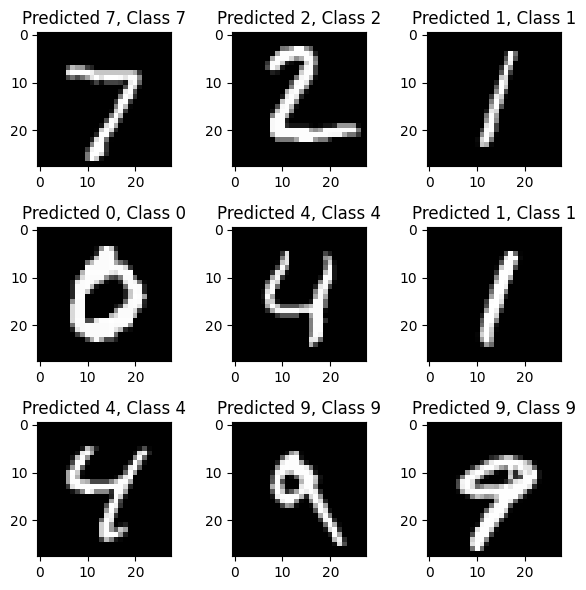

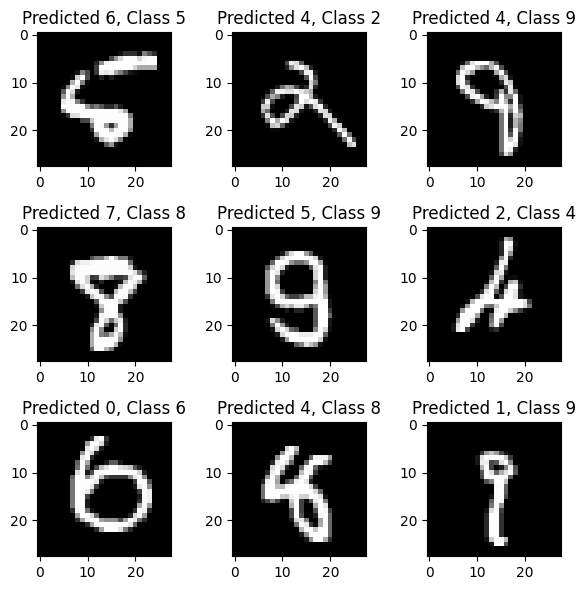

In [ ]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

plt.tight_layout()

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

plt.tight_layout()

#III. Basic DL performance improvement



##1. More data!

In [ ]:
# Reload dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train/255.0
X_test = X_test/255.0

nb_classes = 10

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

In [ ]:
# Build and compile new model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 activation_3 (Activation)   (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
 activation_5 (Activation)   (None, 10)                0         
                                                                 
Total params: 669706 (2.55 MB)
Trainable params: 66970

In [ ]:
# Train the model
model.fit(X_train, Y_train,
          batch_size=128, epochs=8,
          verbose=1)

Epoch 1/8
469/469 [==============================] - 6s 10ms/step - loss: 0.2151 - accuracy: 0.9366
Epoch 2/8
469/469 [==============================] - 5s 11ms/step - loss: 0.0806 - accuracy: 0.9746
Epoch 3/8
469/469 [==============================] - 5s 10ms/step - loss: 0.0505 - accuracy: 0.9840
Epoch 4/8
469/469 [==============================] - 5s 11ms/step - loss: 0.0355 - accuracy: 0.9887
Epoch 5/8
469/469 [==============================] - 5s 10ms/step - loss: 0.0290 - accuracy: 0.9905
Epoch 6/8
469/469 [==============================] - 5s 10ms/step - loss: 0.0214 - accuracy: 0.9928
Epoch 7/8
469/469 [==============================] - 5s 11ms/step - loss: 0.0167 - accuracy: 0.9947
Epoch 8/8
469/469 [==============================] - 5s 10ms/step - loss: 0.0168 - accuracy: 0.9943


In [ ]:
# Evaluate on test set
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0829 - accuracy: 0.9777
Test score: 0.08286621421575546
Test accuracy: 0.9776999950408936


##2. Regularization

In [ ]:
# Dropout zeroes a selection of random outputs (i.e., disables their activation)
# Dropout helps protect the model from memorizing or "overfitting" the training data.


In [ ]:
# Build and compile new model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 activation_6 (Activation)   (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 activation_7 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 10)               

In [ ]:
# Train the model
model.fit(X_train, Y_train,
          batch_size=128, epochs=8,
          verbose=1)

Epoch 1/8
79/79 [==============================] - 1s 18ms/step - loss: 0.0058 - accuracy: 0.9989
Epoch 2/8
79/79 [==============================] - 1s 18ms/step - loss: 0.0115 - accuracy: 0.9969
Epoch 3/8
79/79 [==============================] - 1s 19ms/step - loss: 0.0043 - accuracy: 0.9997
Epoch 4/8
79/79 [==============================] - 1s 18ms/step - loss: 0.0019 - accuracy: 0.9997
Epoch 5/8
79/79 [==============================] - 2s 22ms/step - loss: 7.9152e-04 - accuracy: 1.0000
Epoch 6/8
79/79 [==============================] - 2s 29ms/step - loss: 5.6100e-04 - accuracy: 1.0000
Epoch 7/8
79/79 [==============================] - 2s 29ms/step - loss: 4.6203e-04 - accuracy: 1.0000
Epoch 8/8
79/79 [==============================] - 2s 29ms/step - loss: 3.9439e-04 - accuracy: 1.0000


In [ ]:
# Evaluate on test set
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 4ms/step - loss: 0.1544 - accuracy: 0.9648
Test score: 0.15438495576381683
Test accuracy: 0.9648000001907349


###3. Deeper network

In [ ]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               401920    
                                                                 
 activation_9 (Activation)   (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 activation_10 (Activation)  (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 512)              

In [ ]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=10,
          verbose=1)

Epoch 1/10
469/469 [==============================] - 11s 21ms/step - loss: 0.2730 - accuracy: 0.9177
Epoch 2/10
469/469 [==============================] - 10s 21ms/step - loss: 0.1210 - accuracy: 0.9639
Epoch 3/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0888 - accuracy: 0.9729
Epoch 4/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0754 - accuracy: 0.9770
Epoch 5/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0619 - accuracy: 0.9805
Epoch 6/10
469/469 [==============================] - 10s 20ms/step - loss: 0.0552 - accuracy: 0.9829
Epoch 7/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0478 - accuracy: 0.9853
Epoch 8/10
469/469 [==============================] - 10s 22ms/step - loss: 0.0455 - accuracy: 0.9861
Epoch 9/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0442 - accuracy: 0.9869
Epoch 10/10
469/469 [==============================] - 10s 21ms/step - loss: 0.035

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0713 - accuracy: 0.9824
Test score: 0.07130035758018494
Test accuracy: 0.9824000000953674


###Even more data!

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1,  28, 28, 1)

X_train = X_train/255.0
X_test = X_test/255.0

nb_classes = 10

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

model = Sequential()
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))
model.build(input_shape=(128,784))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1,
                    validation_data=test_generator, validation_steps=10000//128)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (128, 784)                0         
                                                                 
 dense_14 (Dense)            (128, 512)                401920    
                                                                 
 activation_14 (Activation)  (128, 512)                0         
                                                                 
 dropout_6 (Dropout)         (128, 512)                0         
                                                                 
 dense_15 (Dense)            (128, 512)                262656    
                                                                 
 activation_15 (Activation)  (128, 512)                0         
                                                                 
 dropout_7 (Dropout)         (128, 512)               

<ipython-input-30-4e9f8b06b00c>:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1,


468/468 [==============================] - 19s 39ms/step - loss: 0.4314 - accuracy: 0.8658 - val_loss: 0.1028 - val_accuracy: 0.9674
Epoch 2/5
468/468 [==============================] - 18s 38ms/step - loss: 0.1860 - accuracy: 0.9431 - val_loss: 0.0824 - val_accuracy: 0.9746
Epoch 3/5
468/468 [==============================] - 18s 39ms/step - loss: 0.1545 - accuracy: 0.9518 - val_loss: 0.0649 - val_accuracy: 0.9787
Epoch 4/5
468/468 [==============================] - 18s 38ms/step - loss: 0.1342 - accuracy: 0.9589 - val_loss: 0.0642 - val_accuracy: 0.9786
Epoch 5/5
468/468 [==============================] - 18s 39ms/step - loss: 0.1199 - accuracy: 0.9630 - val_loss: 0.0504 - val_accuracy: 0.9833


# Introducing Convolution! What is it?

Before, we built a network that accepts the normalized pixel values of each value and operates soley on those values. What if we could instead feed different features (e.g. **curvature, edges**) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies **kernels** (filters) that traverse through each image and generate **feature maps**.

<img src = 'convolution.gif' >

In the above example, the image is a 5 x 5 matrix and the kernel going over it is a 3 x 3 matrix. A dot product operation takes place between the image and the kernel and the convolved feature is generated. Each kernel in a CNN learns a different characteristic of an image.

Kernels are often used in photoediting software to apply blurring, edge detection, sharpening, etc.

<img src = 'kernels.png' >

Kernels in deep learning networks are used in similar ways, i.e. highlighting some feature. Combined with a system called **max pooling**, the non-highlighted elements are discarded from each feature map, leaving only the features of interest, reducing the number of learned parameters, and decreasing the computational cost (e.g. system memory).

<img src = 'max_pooling.png' >

We can also take convolutions of convolutions -- we can stack as many convolutions as we want, as long as there are enough pixels to fit a kernel.

*Warning: What you may find down there in those deep convolutions may not appear recognizable to you.*

<img src = 'go_deeper.jpg' >

## Building a "Deep" Convolutional Neural Network

In [ ]:
# import some additional tools

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization

ModuleNotFoundError: ignored

In [ ]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# Again, do some formatting
# Except we do not flatten each image into a 784-length vector because we want to perform convolutions first

X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

In [ ]:
# one-hot format classes

nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [ ]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

In [ ]:
model.summary()

In [ ]:
# we'll use the same optimizer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [ ]:
# We can then feed our augmented data in batches
# Besides loss function considerations as before, this method actually results in significant memory savings
# because we are actually LOADING the data into the network in batches before processing each batch

# Before the data was all loaded into memory, but then processed in batches.

train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [ ]:
# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1,
                    validation_data=test_generator, validation_steps=10000//128)

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## Great results!

But wouldn't it be nice if we could visualize those convolutions so that we can see what the model is seeing?

In [ ]:
from keras import backend as K

# choose any image to want by specifying the index
img = X_test[3]
img = np.expand_dims(img, axis=0) # Keras requires the image to be in 4D, so we add an extra dimension to it.

# Not important to understand how this function work -- It just plots a convolution layer

def visualize(layer):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])

    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)

    m = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(m)))

    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(15,12))
    for i in range(m):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')


In [ ]:
plt.figure()
plt.imshow(X_test[3].reshape(28,28), cmap='gray', interpolation='none')

In [ ]:
visualize(convLayer01) # visualize first set of feature maps

In [ ]:
visualize(convLayer02) # visualize second set of feature maps

In [ ]:
visualize(convLayer03)# visualize third set of feature maps

In [ ]:
visualize(convLayer04)# visualize fourth set of feature maps

#### For a 3D visualization of a very similar network, visit http://scs.ryerson.ca/~aharley/vis/conv/